<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Basic/MLP-FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MNIST Fashion MLP

In [2]:
!pip install -q --upgrade wandb

In [3]:
import os
import wandb
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as nn_funcs
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import *

####Prepare gobal variables

In [4]:
TRAIN_BATCH = 64
TEST_BATCH = 512        #Not used
N_IN = 28*28
N_OUT = 10
LR = 0.01
NUM_WORKERS = 2
N_EPOCHS = 10
SEED = 42
MNISTF_MEAN = 0.2859
MNISTF_STD = 0.3530
PARAM_DICT = {'epochs':N_EPOCHS, 'train_batch':TRAIN_BATCH, 'num_workers':NUM_WORKERS, 
              'lr':LR, 'seed':SEED, 'classes':N_OUT}

Logging with wandb

In [5]:
WNB_FLAG = False
API_KEY = ''
WNB_PROJECT = 'MNIST Fashion'
WNB_LOGIN = 'dimildizio'

One seed to rule them all

In [6]:
def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

seed_all(SEED)

#### Load data

In [7]:
transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(MNISTF_MEAN, MNISTF_STD)
                      ])

In [8]:
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = TRAIN_BATCH, 
                                         num_workers = NUM_WORKERS, pin_memory = True,
                                         shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = TEST_BATCH, 
                                         num_workers = NUM_WORKERS, pin_memory = True,
                                         shuffle = False)

Convert batches with 1 channel 28x28 

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

In [10]:
train_loader

In [11]:
images.shape

(64, 1, 28, 28)

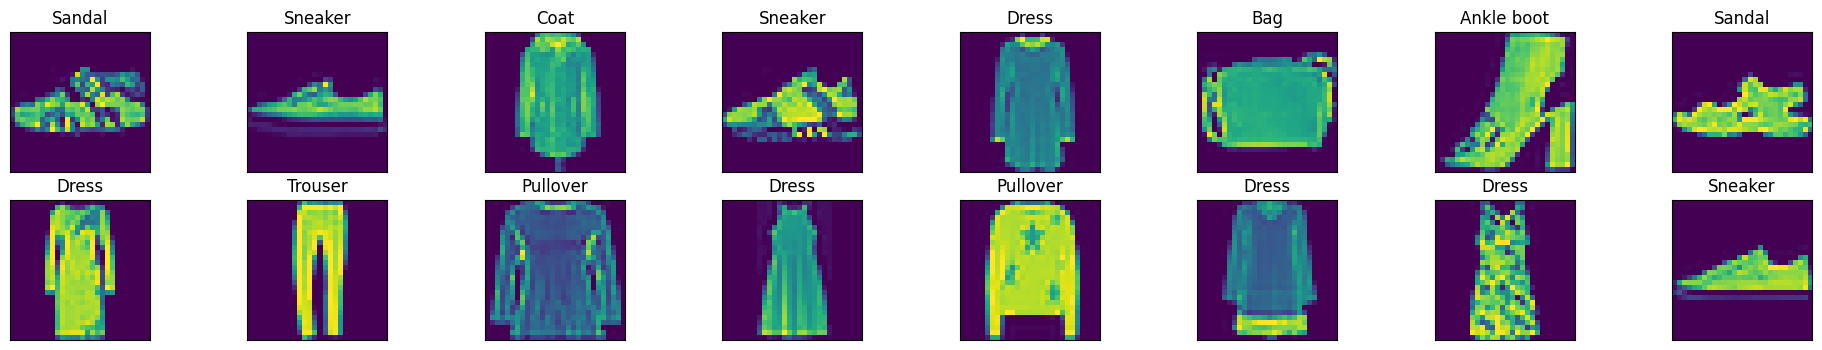

In [12]:
fig = plt.figure(figsize=(24, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    ax.set_title(str(train_data.classes[labels[idx].item()]))

Define a class that has 3 hidden layers with 512 neurons on the 1st *hidden*, 256 on the second and 128 on the third

####Create a class for operations

In [27]:
class ModelRunner:
  def __init__(self, model, optimizer, loss, epochs = N_EPOCHS, traindata = train_loader, testdata = test_loader):
    self.traindata = traindata
    self.testdata = testdata
    self.epochs = epochs

    self.init_model(model, optimizer, loss)
    self.can_cuda()

  def init_model(self, model, optimizer, loss):
    self.model = model
    self.optimizer = optimizer
    self.loss = loss

  def can_cuda(self):
    if torch.cuda.is_available():
      self.model.cuda()
      self.device = torch.device('cuda')
    else:
      self.device = torch.device('cpu')


  def print_n_log(self, correct, iloss, name = 'Train'):
    myset = self.traindata if name == 'Train' else self.testdata
    predicted_well =correct / len(myset.dataset)
    tqdm.write(f'{name}: Avg loss: {iloss} Accuracy: {round(100 * predicted_well,3)}%')   
    if WNB_FLAG:
      wandb.log({name+'_loss':iloss, 
                 name+'_accuracy':predicted_well})

  def get_correct_score(self, predictions, target):
      pred_p = predictions.argmax(dim=1, keepdim=True) #get index of the highest probability
      correct_mask = pred_p.eq(target.view_as(pred_p)) #get True\False match of predcited\true results
      return correct_mask.sum().item()                 #sum and return scalar to add to correct values

  def train(self):
    correct = 0 
    self.model.train()  #train mode
    #train batch by batch 
    for _batch_idx, (data, target) in tqdm(enumerate(self.traindata), total=len(self.traindata)):
      #set to device
      data = data.to(self.device)
      target = target.to(self.device)
      self.optimizer.zero_grad()                       #zero the gradients  

      preds = self.model(data)                         #calc probablities for every class
      correct += self.get_correct_score(preds, target) #add correctly predicted values

      train_loss = self.loss(preds, target)            #calc loss
      train_loss.backward()                            #compute gradient of loss                            
      self.optimizer.step()                            #grad step and w&b update

    self.print_n_log(correct, train_loss)              #log and print out results of an epoch


  def test(self):
    correct = 0
    self.model.eval()  #inference mode
    #self.testdata is not bin batches
    with torch.no_grad():                               #test set. we don't updating wnb
      for data, target in self.testdata:
        #set to device
        data = data.to(self.device)
        target = target.to(self.device)

        preds = self.model(data)                          #get probabilites for classes
        correct += self.get_correct_score(preds, target)  #add the num of correctly predicted values
        test_loss = self.loss(preds, target)              #calc loss

    self.print_n_log(correct, test_loss, 'Test')          #log n print accuracy and loss

  def run_loop(self):
    print('TOTAL EPOCHS:', self.epochs)
    for epoch in range(self.epochs+1):
      print('Epoch:', epoch)
      self.train()
      self.test()
      print()

In [14]:
def log_wnb(model):
  if WNB_FLAG:
    os.environ["WANDB_API_KEY"] = API_KEY
    wandb.init(project=WNB_PROJECT, entity=WNB_LOGIN, reinit=True, config=PARAM_DICT)
    wandb.watch(model, log='all')

In [15]:
def mainloop(model, optimizer, loss, epochs):
  seed_all(SEED)
  runner = ModelRunner(model, optimizer, loss, epochs = epochs)
  log_wnb(model)
  runner.run_loop()

Get GPU info

In [26]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Thu Apr 27 23:59:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |    847MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
class MyNet(nn.Module):
  def __init__(self):
    super(MyNet, self).__init__()
    hidden1 = 128
    hidden2 = 256
    hidden3 = 128
    self.fc1 = nn.Linear(N_IN, hidden1)
    self.fc2 = nn.Linear(hidden1, hidden2)
    self.fc3 = nn.Linear(hidden2, hidden3)
    self.fc4 = nn.Linear(hidden3, N_OUT)

  def forward(self, x):
    x = x.view(-1, N_IN)
    x = nn_funcs.leaky_relu(self.fc1(x))
    x = nn_funcs.leaky_relu(self.fc2(x))
    x = nn_funcs.leaky_relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [25]:
model = MyNet()
loss = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

mainloop(model, optimizer, loss, 10)

EPOCHS: 10


100%|██████████| 938/938 [00:15<00:00, 59.34it/s]


Train: Avg loss: 7.721004009246826 Accuracy: 82.352%



Test: Avg loss: 87.543212890625 Accuracy: 84.99%



100%|██████████| 938/938 [00:15<00:00, 59.64it/s]


Train: Avg loss: 12.16502571105957 Accuracy: 86.922%



Test: Avg loss: 72.92431640625 Accuracy: 86.4%



100%|██████████| 938/938 [00:16<00:00, 58.53it/s]


Train: Avg loss: 7.590438365936279 Accuracy: 88.192%



Test: Avg loss: 68.92808532714844 Accuracy: 86.14%



100%|██████████| 938/938 [00:16<00:00, 58.22it/s]


Train: Avg loss: 11.270520210266113 Accuracy: 89.173%



Test: Avg loss: 69.63525390625 Accuracy: 87.38%



100%|██████████| 938/938 [00:15<00:00, 59.40it/s]


Train: Avg loss: 9.671599388122559 Accuracy: 89.837%



Test: Avg loss: 59.48044204711914 Accuracy: 87.75%



100%|██████████| 938/938 [00:15<00:00, 59.87it/s]


Train: Avg loss: 5.2407755851745605 Accuracy: 90.275%



Test: Avg loss: 67.30949401855469 Accuracy: 87.86%



100%|██████████| 938/938 [00:16<00:00, 56.47it/s]


Train: Avg loss: 7.683635234832764 Accuracy: 90.835%



Test: Avg loss: 61.184234619140625 Accuracy: 88.25%



100%|██████████| 938/938 [00:16<00:00, 56.97it/s]


Train: Avg loss: 4.839700698852539 Accuracy: 91.335%



Test: Avg loss: 61.821964263916016 Accuracy: 88.35%



100%|██████████| 938/938 [00:15<00:00, 59.41it/s]


Train: Avg loss: 9.882068634033203 Accuracy: 91.552%



Test: Avg loss: 79.98644256591797 Accuracy: 88.13%



100%|██████████| 938/938 [00:15<00:00, 59.68it/s]


Train: Avg loss: 11.780071258544922 Accuracy: 92.057%



Test: Avg loss: 76.39363098144531 Accuracy: 87.95%



100%|██████████| 938/938 [00:15<00:00, 59.96it/s]


Train: Avg loss: 12.687047958374023 Accuracy: 92.393%



Test: Avg loss: 62.824119567871094 Accuracy: 88.6%



So even with the baseline we got the desired resut of 88%